In [1]:
# ML_in_Finance-RNNs-Bitcoin
# Author: Matthew Dixon
# Version: 1.1 (27.2.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# tensorflow=2.0.0, keras=2.3.1, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3, statsmodels=0.10.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

## An Introduction to Prediction with RNNs

### Overview
- This notebook provides an example of how Keras can be used to train and test TensorFlow RNNs for time series prediction. The example dataset is for predicting from noisy, non-stationary data.
- Statistical methods used for autoregressive models shall be used to identify the sequence length needed in the RNN and to diagnose the model error.
- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationary data, since these models exhibit dynamic auto-correlation structure.
- Unlike classical time series methods, e.g. ARIMA, there are no parametric assumptions on the distribution of the errors, and non-linear relationships between response and predictors can be captured. 
- The data is snapshots of the USD value of Coinbase every minute over 2018.

#### Statistician's note
- We choose to build a model which provides strong predictive power, at the expense of reduced explanatory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' - identifying the relevant features to include in the model. 

- In this notebook, we assume that we've already identifed the relevant set of features (i.e. there is only one time series provided).
- Our primary concern is assessing the extent to which the model is over-fitting, by comparing the in- and out-of-sample MSEs.

#### Implementation notes
- It is important to ensure that `shuffle=False` in the fit function, otherwise the ordering of sequences is not preserved. This is especially important for methods which have memory beyond the current sequence (i.e. all methods except RNNs).
- Time series cross-validation must be used for hyper-parameter tuning because the ordering of the data matters. In particular, the model must never use training data more recent than the forecasting observation date.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV


from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# note that the directory containing these two .py's must be in the path variable:
#from alphaRNN import AlphaRNN
#from alphatRNN import AlphatRNN

2024-03-08 08:50:13.668734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow.keras as keras

In [3]:
%matplotlib inline

### Example Data
- The example dataset $X$ is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- Each observation in $X$ has one variable (a.k.a. univariate time series).

Loading the data into a Pandas Dataframe, then viewing the first ten observations and the distribution of the labels:

In [5]:
df = pd.read_csv('coinbase.csv', index_col=1)

df.index = pd.to_datetime(df.index)

The dataset contains missing values; in order to prevent this causing errors, we replace these with adjacent values from the time series.

In [6]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [8]:
df = df.ffill()

nof_missing_values = sum(np.isnan(df['USD']))

print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


# RNN Regression
We consider a univariate prediction problem where the time series is given by 'USD' in the data frame, and for each input sequence we predict the value 4 time-steps into the future.

In [9]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon

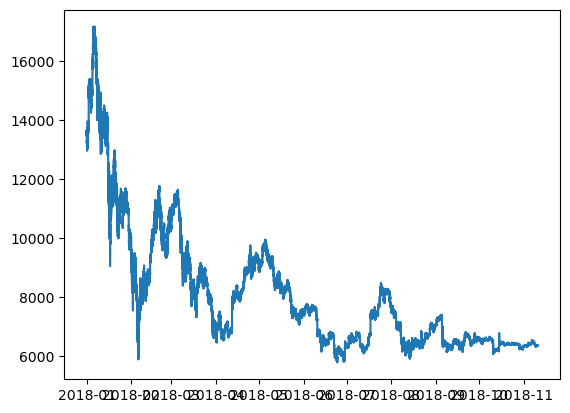

In [10]:
plt.plot(df['USD'])

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostic tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.



The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the memory requirements of the test. We use the first 200,000 samples to test for stationarity. While the test statistic is sensitive to the data size, the ADF test is always accepted at the 99\% level.

In [11]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [12]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.094557163375749
p-value: 0.24670881839395753,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


Here we accept the null as the p-value is larger than 0.01, thus we can not reject the test at the 99% confidence level. This suggests that the time series is **non-stationary**.

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [13]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

Since $\Phi^{-1}(0.99) \simeq 2.58$:

In [14]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [15]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 4 lags appears satisfactory, although more may be needed. Unlike autoregressive models, the advantage of using fewer parameters is purely computational as adding more lags does not increase the number of parameters, only the size of the tensorial representation of the sequence data in TensorFlow. 

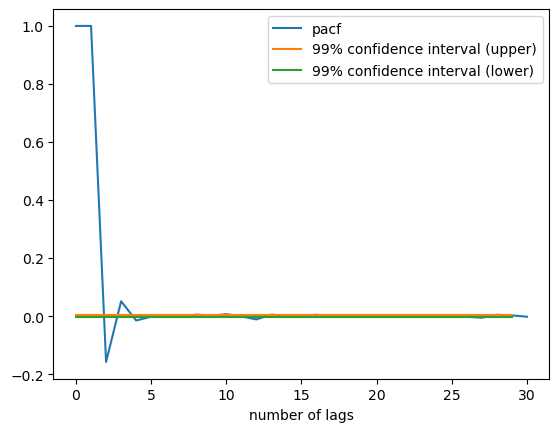

In [16]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

### Splitting the time series into training and testing sets
Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [17]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]


### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [28]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = float(df_train.mean().iloc[0])
sigma = float(df_train.std().iloc[0])

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. 

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, for example, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15


Let's define the following function for reshaping the data into one-step ahead times series prediction format. 

In [30]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

We shall first transform the training input and output data.

In [31]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

Print the shapes of each tensor. The first digit is the number of observations. For feature arrays, the second digit is the sequence length (i.e. the number of lags in the model) and the final digit is the dimension of each element in the sequence or output vector respectively. In this case, the example performs univariate time series analysis and so the dimension of the input and output is 1.

In [32]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(361337, 4, 1), (361337, 1), (90330, 4, 1), (90330, 1)]


### Model Specification

In [38]:
#def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
#  model = Sequential()
#  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
#  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
#  model.compile(loss='mean_squared_error', optimizer='adam')
#  return model


#def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
#  model = Sequential()
#  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))
#  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
#  model.compile(loss='mean_squared_error', optimizer='adam')
#  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [39]:
max_epochs = 50
batch_size = 1000

Use a batch size of 1000 as the dataset is reasonably large and the training time would be too long otherwise. 20 epochs have been used here, but a better approach would be to use a stopping criteria through a call back. 

In [40]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3, min_delta=1e-7, restore_best_weights=True)

In [41]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
   # 'alpharnn': {
   #     'model': None, 'function': AlphaRNN_, 'l1_reg': 0.0, 'H': 10, 
   #     'color': 'green', 'label': '$\\alpha$-RNN' }, 
   # 'alphatrnn': {
   #     'model': None, 'function':AlphatRNN_, 'l1_reg': 0.0, 'H': 5, 
   #     'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

# Optionally, load pre-trained models
Training the models takes several hours. To save time, you may load the already fitted models instead:

In [42]:
do_training = True # Set to True if you wish to train your own models

In [43]:
if do_training is False:
    custom_objects = {'AlphaRNN': AlphaRNN, 'AlphatRNN': AlphatRNN}
    for key in params.keys():
        params[key]['model'] = load_model('trained-RNNs/RNNs-Bitcoin-' + key + '.hdf5', custom_objects=custom_objects)

# Cross-validation

The cell below performs a grid search to optimise the `n_units` and `l1_reg` for each of the models using the training data. 

The results are cross-validated to avoid over-fitting. Scikit-Learn's `TimeSeriesSplit` function is used to partition the data into 5 pairs of training and testing sets, where the test data is always ahead of the training data in time. 

In [44]:
cross_val = False # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

# Train cross-validated model

If the grid search was performed, the parameters `n_units` and `l1_reg` with the best average performance across the cross-validation splits are used to train the models on the entire training set. If not, the values from the initialisation of `params` above are used.

In [45]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model


2024-03-08 09:26:33.610566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
362/362 [==============================] - 3s 1ms/step - loss: 0.0096
Epoch 2/50
362/362 [==============================] - 1s 2ms/step - loss: 0.0136
Epoch 3/50
362/362 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 4/50
362/362 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 4: early stopping
Training gru model
Epoch 1/50
362/362 [==============================] - 2s 3ms/step - loss: 1.4727
Epoch 2/50
362/362 [==============================] - 1s 3ms/step - loss: 0.4364
Epoch 3/50
362/362 [==============================] - 1s 3ms/step - loss: 0.1909
Epoch 4/50
362/362 [==============================] - 1s 3ms/step - loss: 0.1104
Epoch 5/50
362/362 [==============================] - 1s 3ms/step - loss: 0.0708
Epoch 6/50
362/362 [==============================] - 1s 3ms/step - loss: 0.0494
Epoch 7/50
362/362 [==============================] - 1s 3ms/step - loss: 0.0369
Epoch 8/50
362/362 [==============================] - 1s 3ms/step 

Optionally save the fitted models:

In [46]:
for key in params.keys():
    params[key]['model'].save('RNNs-Bitcoin-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

### Print out the value of $\alpha \in [0,1]$ for the alpha-RNN model:

In [47]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [48]:
#model = params['alpharnn']['model']
#names = [weight.name for layer in model.layers for weight in layer.weights]
#weights = model.get_weights()
#
#for name, weight in zip(names, weights):
#    if 'alpha:0' in name:
#        print("alpha = " + str(sigmoid(weight)))

### Prediction

We shall now apply the fitted RNN models to the training set and the test set, separately. We can then informally assess the extent of over-fitting.

In [49]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                440       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
2823/2823 [==============================] - 2s 777us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                390       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                           

### Model Performance

Finally assess the performance of the model in and out-of-sample using the MSE. We expect the mean error to be larger on the test set than on the training set. 

In [50]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

# Upper limits for `l` & `u` in the cells below:

training set: 361337
testing set: 90330


In [51]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['rnn', 'gru', 'lstm'])


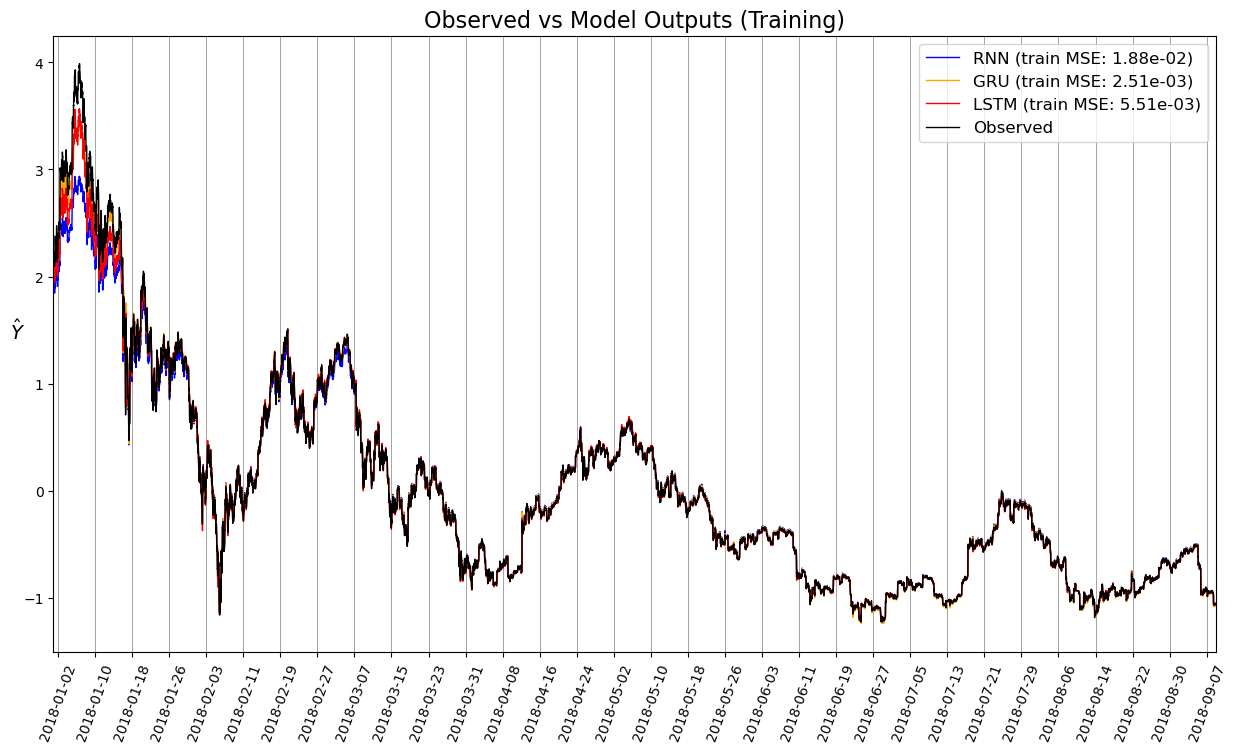

In [52]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

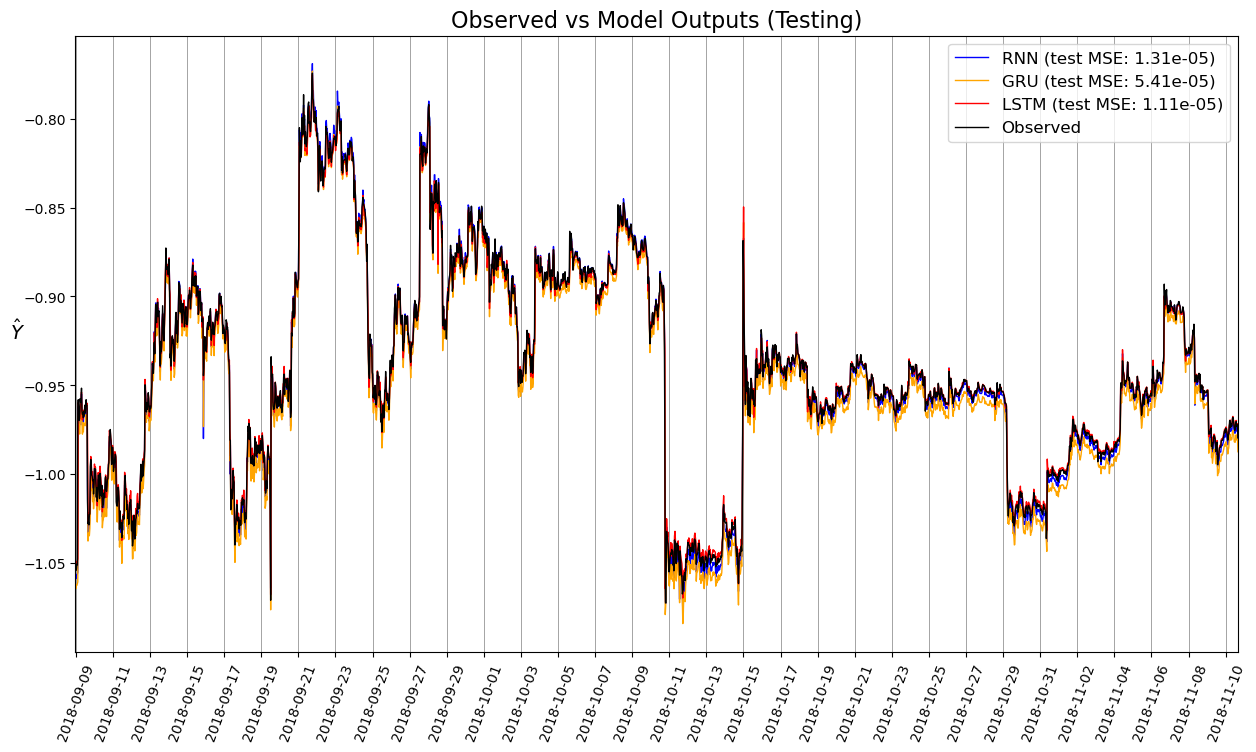

In [53]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

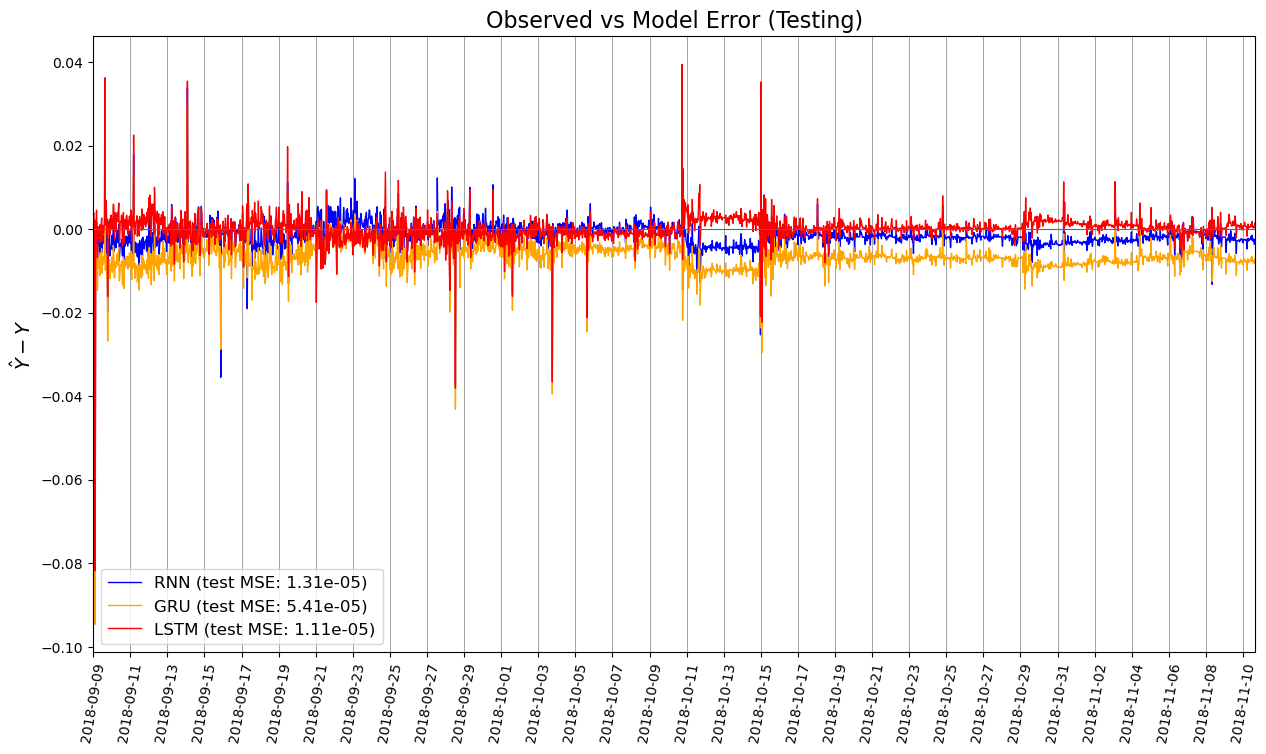

In [54]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

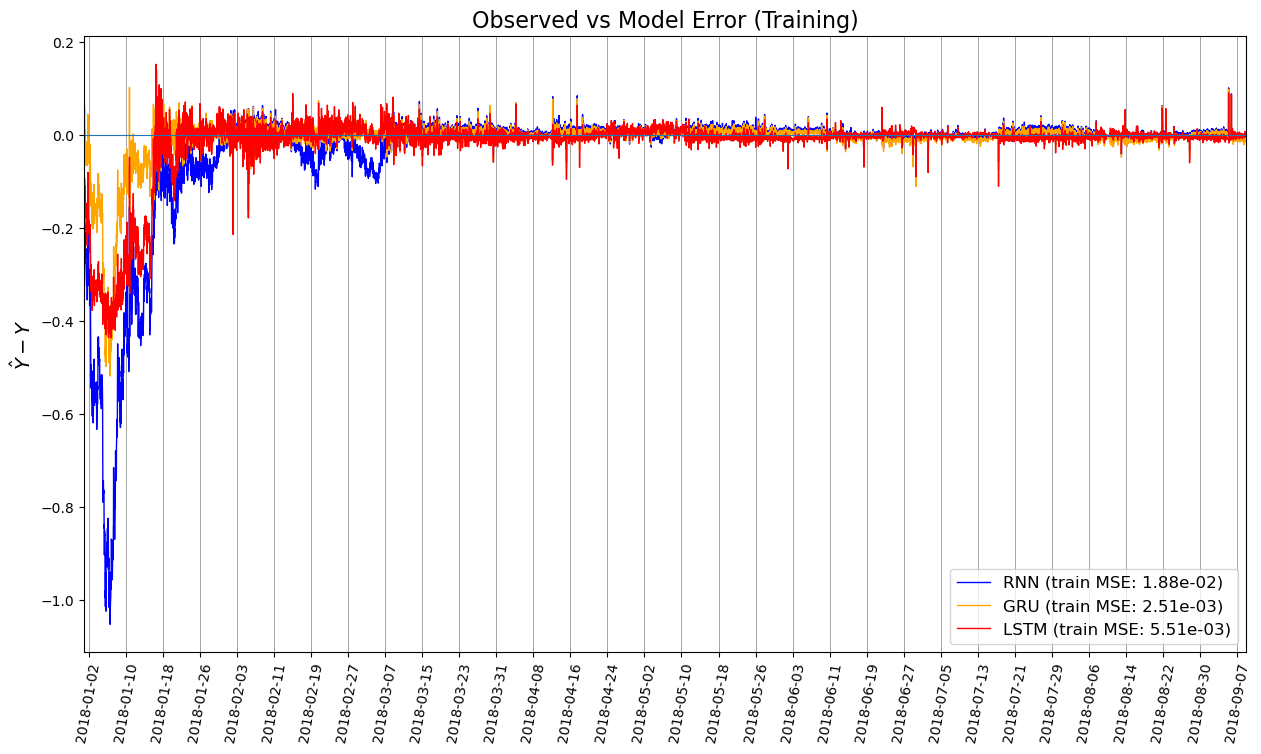

In [55]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);

### Model Diagnostics

A fitted time series model must be examined for underfitting with a white noise test. We analyze the model residuals (i.e. the error $u_t$) to determine whether it is white noise or whether it is auto-correlated. The latter case provides statistical evidence that more lags are needed in the RNN. Box and Pierce propose the Portmanteau statistic:

$$Q^*(m)=T\sum_{l=1}^m\hat{\tau}_l^2,$$  
as a test statistic for the null hypothesis $H_0:\tau_1=\dots=\tau_m=0$ against the alternative hypothesis $H_a:\tau_i\neq 0$ for some $i\in\{1,\dots,m\}$, where $T$ is the number of observations, $\hat{\tau}_i$ are the sample autocorrelations of the residual, and $m$ is the maximum lag used in the test. There are several heuristics in the statistics literature to determine the maximum lag such as the Schwert statistic. 

The Box-Pierce statistic follows an asymptotically chi-squared distribution with $m$ degrees of freedom.

The Ljung-Box test statistic increases the power of the test in finite samples:
$$Q(m)=T(T+2)\sum_{l=1}^m\frac{\hat{\tau}_l^2}{T-l}$$
This statistic also follows an asymptotically chi-squared distribution with $m$ degrees of freedom. The decision rule is to reject $H_0$ if $Q(m)>\chi_{\alpha}^2$ where $\chi_{\alpha}^2$ denotes the $100(1-\alpha)^{th}$ percentile of a chi-squared distribution with m degrees of freedom and is the significance level for rejecting $H_0$.

The test can be time consuming and we select a subset of the residuals. Here we simply set the maximum lag to 20. In the results below, we find that the p-values are all smaller than 0.01, indicating that we can reject the null at the 99% confidence level for any lag. This is strong evidence that the model is under-fitting and more lags are needed in our model. Unlike an auto-regressive model, increasing the number of lags in the RNN does not increase the number of weights. Thus there is no danger of over-fitting by increasing the lag, although there will be an increase in the training time.

In [56]:
# number of samples to use for computing test statistic
n = 100000

In [57]:
params.keys()

dict_keys(['rnn', 'gru', 'lstm'])

In [59]:
key = 'rnn'
predicted = params[key]['pred_test']
residual = y_test[-n:] - predicted[-n:]

In [60]:
lb, p = sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)

The Box-Ljung test statistics are

In [61]:
lb

'lb_stat'

The p-values are

In [62]:
p

'lb_pvalue'